# 海森堡模型的求解和纠缠熵的计算

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/mindspore_heisenberg_model_and_entanglement.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/mindspore_heisenberg_model_and_entanglement.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/mindspore_heisenberg_model_and_entanglement.ipynb)

## 概述
海森堡模型（英语：Heisenberg model）是一个自旋系统的统计力学的模型，常被用来研究磁性系统和强关联电子系统中的相变与临界点的现象。在变分量子线路的研究中，海森堡模型因为其清晰、简洁的物理图景，一直是比较热门的话题。

本文将从海森堡模型出发，按照如下三个部分展开，探讨海森堡模型的优化过程各个参量的变化，包括纠缠熵、梯度模长等。

- 搭建海森堡模型；
- 纠缠熵的计算；
- 优化算法与验证。

## 根据图搭建海森堡模型

我们知道，海森堡模型的哈密顿量为：
$$
H=\sum_{i, j \in V_{\mathcal{G}}} J\left(\sigma_i^z \sigma_j^z+\sigma_i^y \sigma_j^y+\sigma_i^x \sigma_j^x\right)+h_z \sum_{i=1}^N \sigma_i^z
$$
其中$V_{\mathcal{G}}$是表示一个图 $\mathcal{G}$ 的节点 (vertex) 的集合。第二个求和号上的$N$指的是总节点数，也就是模拟线路的比特数。根据这个我们可以通过```networkx```来生成一个图，再去遍历它的节点和边，生成海森堡模型的哈密顿量。

首先导入需要的包

In [1]:
import networkx as nx
from mindquantum import QubitOperator, Hamiltonian

接着，为了方便演示，使用`networkx`生成一个随机的正则图：

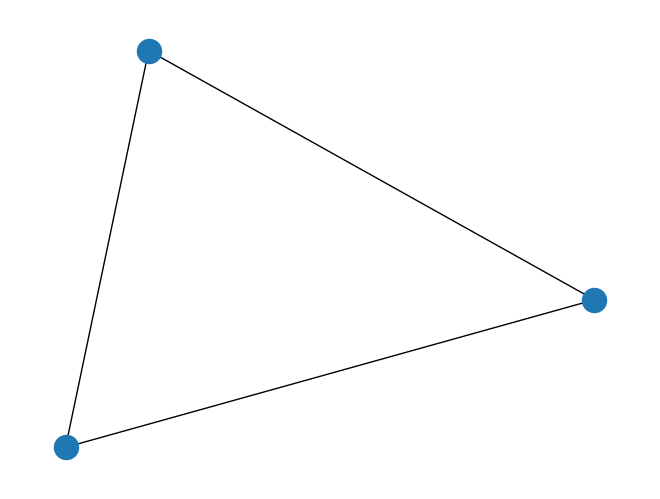

In [2]:
graph = nx.random_graphs.random_regular_graph(2, 3) # 生成一个随机正则图
nx.draw(graph) #绘制图形

接下来，我们把海森堡模型的公式套用进去，具体操作就是（假设$J=h_z=1$）

In [3]:
J = 1
h_z = 1
ham = QubitOperator()
for i in graph.edges: # 遍历图形的边，添加磁矩间的相互作用
    ham += J * QubitOperator(f'X{i[0]} X{i[1]}')
    ham += J * QubitOperator(f'Y{i[0]} Y{i[1]}')
    ham += J * QubitOperator(f'Z{i[0]} Z{i[1]}')

for i in graph.nodes: # 遍历图形的节点，添加外磁场
    ham += h_z * QubitOperator(f'Z{i}')

print(ham) #打印哈密顿量

1 [X0 X1] +
1 [Y0 Y1] +
1 [Z0 Z1] +
1 [X0 X2] +
1 [Y0 Y2] +
1 [Z0 Z2] +
1 [X1 X2] +
1 [Y1 Y2] +
1 [Z1 Z2] +
1 [Z0] +
1 [Z1] +
1 [Z2] 


海森堡模型的哈密顿量搭建的核心逻辑我们已经搞清楚了，接下来，方便起见，我们可以把这些操作封装成一个类：

In [4]:
class HeisenbergModel:
    
    def __init__(self, J, h_z, graph: nx.Graph):
        self.J = J
        self.h_z = h_z
        self.graph = graph
        self.n_qubits = graph.number_of_nodes()

    def ham(self) -> Hamiltonian:
        ham = QubitOperator()
        for i in self.graph.edges:
            ham += self.J * QubitOperator(f'X{i[0]} X{i[1]}')
            ham += self.J * QubitOperator(f'Y{i[0]} Y{i[1]}')
            ham += self.J * QubitOperator(f'Z{i[0]} Z{i[1]}')
        for i in self.graph.nodes:
            ham += self.h_z * QubitOperator(f'Z{i}')
        return Hamiltonian(ham)

    def draw_graph(self) -> None:
        nx.draw(self.graph)

## 计算两体纠缠熵

```mindquantum``` 主要由一个基于矢量的模拟器来实现量子态在量子线路中的演化，因此只能模拟纯态。如果想求两体纠缠熵不可避免的需要去求子系统的密度矩阵，这其中涉及一个偏迹 (partial trace) 这么一个指标缩并的操作。

综上，分两步走，先计算全体系的密度矩阵 $\rho=|\psi\rangle\langle\psi|$ ，其中$|\psi\rangle$可以通过 ```Simulator.get_qs()```方法得到，再通过 ```numpy.outer(psi,psi.conjugate())```就能得到 $\rho$，注意到这是个纯态 $\mathrm{rank}(\rho)=1$。

接着，下面是一个适配于```mindquantum```模拟器的求子系统密度矩阵的方法：

In [5]:
import numpy as np

def get_rs(rho: np.array, list_qubits2keep: list) -> np.array:
    list_qubits2traceout = list(set(range(int(np.log2(len(rho))))) - set(list_qubits2keep))
    counter_qubits = int(np.log2(len(rho)))
    rho_tensor = rho.reshape((2, 2) * counter_qubits)
    for i in list_qubits2traceout:
        index2trace = i - list_qubits2traceout.index(i)
        rho_tensor = np.trace(rho_tensor, axis1=counter_qubits - 1 - index2trace,
                              axis2=2 * counter_qubits - 1 - index2trace)
        counter_qubits += -1
    rho_rs = rho_tensor.reshape(2 ** counter_qubits, 2 ** counter_qubits)
    return rho_rs

这个方法主要基于```numpy.reshape()```和对不同轴的```numpy.trace()```，就是一堆繁琐的角标缩并的操作，看起来代码很多但是信息量不小，容易看晕，读者大可复制粘贴把这段代码当黑箱子用。我在这里简单测试一下这个方法，例如我们搭建一个这样的线路：

In [6]:
from mindquantum import Circuit, H, CNOT, Simulator

circ = Circuit([H.on(0), CNOT.on(1, 0)])
circ.svg()

这是一个典型的制备贝尔态的线路，我们引入模拟器求出态矢量并做外积就能得到整个系统的密度矩阵，如下：

In [7]:
sim = Simulator('mqvector', 2)
sim.apply_circuit(circ)
psi = sim.get_qs()
rho = np.outer(psi, psi.conjugate())

`rho`就是整个系统的密度矩阵。接着，加入我们想得到`q0`位置的约化密度矩阵，我们可以这样调用`get_qs`

In [8]:
get_rs(rho, [0])

array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])

`get_qs()` 传入的第一个参数是密度矩阵，第二个参数是待求子系统的角标组成的列表。不难发现，这个贝尔态得到的第一个子系统的约化密度算子是个最大混态，即 $I/2$ 。

求出约化密度算子以后，就非常容易去计算两体纠缠熵了，我简单把这几个方法列在这里，

In [9]:
def purity(density_matrix):
    """
    :param density_matrix: reduced density matrix to compute purity;
    :return: purity = Tr(rho^2).
    """
    rho2 = np.matmul(density_matrix, density_matrix)
    return np.trace(rho2).real


def s2(density_matrix):
    """
    :param density_matrix: reduced density matrix to compute entropy;
    :return: second Renyi entropy.
    """
    rho2 = np.matmul(density_matrix, density_matrix)
    return -np.log(np.trace(rho2)).real

def get_rs_from_sim(sim_, list_qubits2keep):
    qs = sim_.get_qs()
    rho = np.outer(qs, qs.conjugate())
    reduced_state = get_rs(rho, list_qubits2keep)
    return reduced_state


def s_page(n_subsys, n_sys) -> float:
    """
    Get the approximate page entropy in the limit dim_sys >> dim_subsys.
    :param n_subsys: the number of qubits of subsystem;
    :param n_sys: the number of qubits of system;
    :return: the page entropy.
    """
    k = n_subsys
    N = n_sys
    return k * np.log(2) - 1 / 2 ** (N - 2 * k + 1)

`purity`是用来算纯度的，我们知道纯度等于$\mathrm{Tr}(\rho^2)$，所以我们只需要计算约化密度矩阵的平方，再求迹即可。`s2`为二阶瑞丽熵(2nd order Renyi entropy)，等于对纯度取负log。以上列出的方法互相之间没有依赖关系，可以随意挑选复制到任何地方使用。

## 使用优化算法求解海森堡模型

我们可以写一个最简单的梯度下降算法来优化我们的模型，梯度下降的核心是
$$
\boldsymbol{\theta}^{t+1}=\boldsymbol{\theta}^t-\eta \nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta})
$$
代码实现非常容易，核心就是每一步迭代的时候根据梯度更新参数值：
```python
# Train 1 step.
args += - eta * grad(args)
```
根据这个原理，我们可以写一个类来执行梯度下降算法，并且封装一个绘制优化过程的方法：

In [10]:
import matplotlib.pyplot as plt


class GDOpt:

    def __init__(self, func, grad, args_init: np.array, eta: float):
        self.func = func
        self.grad = grad
        self.args_init = args_init
        self.args = args_init
        self.curve = [self.func(self.args_init)]
        self.eta = eta

    def one_step_opt(self) -> None:
        """
        Train 1 step.
        """
        self.args += - self.eta * self.grad(self.args)
        self.curve.append(self.func(self.args))

    def multi_step_opt(self, steps: int) -> None:
        """
        Train multiple times.
        :param steps: training steps.
        """
        for _ in range(steps):
            self.one_step_opt()

    def plotCurve(self, y: str = None, saveas: str = None) -> None:
        """
        :param y: name of y axis;
        :param saveas: file name to save as *.pdf;
        """
        fig, axe = plt.subplots(1)
        axe.plot(self.curve)
        axe.set(xlabel='Steps', ylabel=y)
        if saveas is not None:
            plt.savefig(saveas + '.pdf')
        else:
            pass
        plt.show()

接下来，我们可以使用上面所列出的方法复现一下这篇文章里的内容 [PRXQuantum.3.020365](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.020365)。根据这篇文章，我们的主要目标是跟踪优化过程中这三个量的变化：1. 成本函数的值；2. 成本函数的梯度模长；3. 二阶瑞丽熵。因此我们可以简单地写一个返回分别由这三个值构成的list的方法：

In [11]:
from tqdm import trange # 引一个可以打印进度条的包

def train(heisenberg_model: HeisenbergModel,
          pqc: Circuit, 
          steps: int, 
          eta: float,
          list_qubits2keep: list,
          eps_theta: float = 0.05) -> tuple((list, list, list)):
    ham = heisenberg_model.ham()
    sim = Simulator('mqvector', heisenberg_model.n_qubits)
    exp_with_grad = sim.get_expectation_with_grad(ham, pqc)

    def func(args):
        f, g = exp_with_grad(args)
        return f[0, 0].real

    def grad(args):
        f, g = exp_with_grad(args)
        return g[0, 0].real
    
    args_init = (np.random.rand(len(pqc.params_name)) * 2 * np.pi - np.pi) * eps_theta
    opt = GDOpt(func, grad, args_init, eta)
    s2_list = []
    grad_norm_list = []
    for _ in trange(steps):
        opt.one_step_opt()
        grad_norm_list.append(np.linalg.norm(opt.grad(opt.args)))
        sim_temp = Simulator('mqvector', heisenberg_model.n_qubits)
        sim_temp.apply_circuit(pqc, opt.args)
        rs = get_rs_from_sim(sim_temp, list_qubits2keep)
        s2_list.append(s2(rs))
    cost_list = opt.curve[1:]
    return s2_list, cost_list, grad_norm_list

方便起见，我们测试一个简单的例子，看看和文章中的结果是否相符。

首先我们先解决搭建线路的问题，这里只是举个例子，采用了随机线路，通过下面的`bpansatz`来产生：

In [12]:
from mindquantum import RX, RY, RZ, Z, UN


def RP(rotation_angle):
    """
    :param rotation_angle: parameter of the gate;
    :return: randomly return one of RX, RY, and RZ with equal probability.
    """
    a = np.random.randint(0, 3)
    if a == 0:
        return RX(rotation_angle)
    elif a == 1:
        return RY(rotation_angle)
    elif a == 2:
        return RZ(rotation_angle)
    else:
        print("error in random Pauli gates")


def bpansatz(n, p):
    """
    :param n: number of qubits;
    :param p: number of layers;
    :return: an 1 dimensional random circuit with n qubits and p layers.
    """
    qc = Circuit()
    for j in range(p):
        for i in range(n):
            qc += RP(f'c({j},{i})').on(i)
        for ii in range(n - 1):
            qc += Z(ii, ii + 1)
        qc += Z(0, n-1)
    return qc


def init_state(n):
    """
    :param n: number of qubits;
    :return: a circuit for state preparation.
    """
    qc = Circuit()
    qc += UN(RY(np.pi / 4), range(n))
    return qc

先搭建一个比特数为4、层数为6的线路，并打印出这个线路的前12个量子门。

In [13]:
n = 4
p = 6
circ = init_state(n) + bpansatz(n, p)
circ[:12].svg()

接着我们创建一个度为2、4个节点的随机正则图：

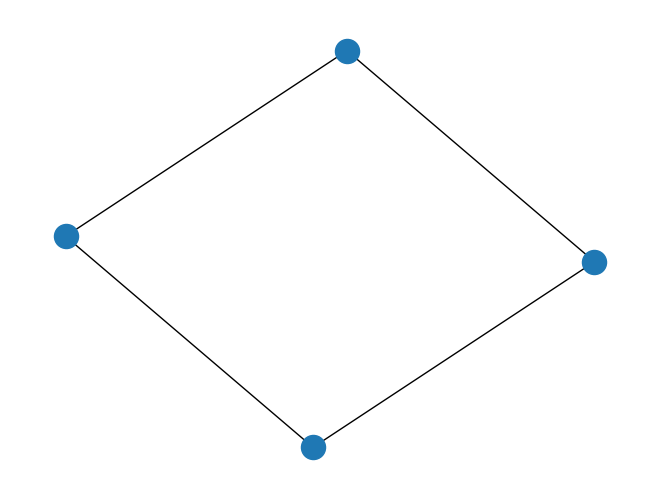

In [14]:
graph = nx.random_graphs.random_regular_graph(2, n)
nx.draw(graph)

接着，我们调用刚才写好的```train()```方法，设置 `steps=100` 训练这个模型100次。

In [15]:
s2list, costlist, gradlist = train(
            HeisenbergModel(1, 1, graph=graph),
            circ,
            steps=100,
            eta=1e-1,
            list_qubits2keep=[0, 1],
        )

100%|██████████| 100/100 [00:00<00:00, 1999.60it/s]


这里 `list_qubits2keep=[0, 1]`指的是我们计算纠缠熵的时候，只保留`q0`和`q1`这两个量子比特，其他比特都trace掉。

最后使用```matplotlib.pyplot```绘图

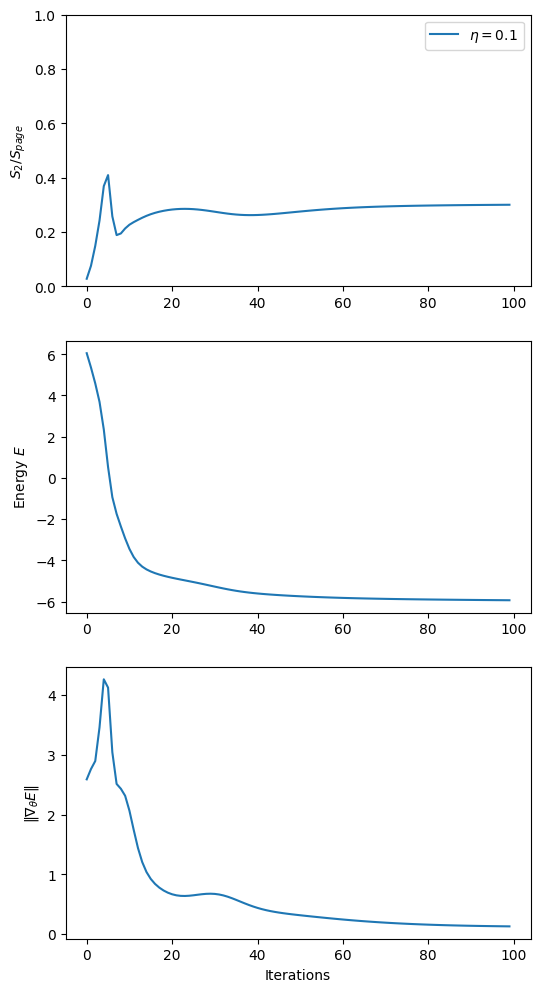

In [16]:
fig, axs = plt.subplots(3, figsize=(6, 12))
axs[0].plot(np.array(s2list) / (s_page(2, 6)), label=(r'$\eta=$' + f'{1e-1}'))
axs[1].plot(costlist)
axs[2].plot(gradlist)
axs[0].set(ylabel=r'$S_2 / S_{page}$',
               ylim=(0, 1))
axs[1].set(ylabel=r'Energy $E$')
axs[2].set(ylabel=r'$\Vert \nabla_\theta E \Vert$',
            xlabel='Iterations')
axs[0].legend(loc='upper right')

不难发现，这个运行结果和这篇文章中的结果还是比较相符的。

若想查询更多关于MindQuantum的API，请点击：[https://mindspore.cn/mindquantum/](https://mindspore.cn/mindquantum/)。